# WHODAS 2.0 functionality prediction 

**Authors:** *Santiago de Leon*, *Jesús Herrera López*, *Emese Sükei*

One-month long time-series data were summarized using statistical measures (minimum, maximum, mean, median, standard deviation, IQR), creating 64 features. We then applied a sequential feature selection on each WHODAS 2.0 domain (cognition, mobility, self-care, getting along, life activities, participation). Finally, we predicted the WHODAS 2.0 functional domain scores using linear regression using the best feature subsets. We reported the mean absolute errors and the mean absolute percentage errors as goodness-of-fit statistics to evaluate the model. 

In [2]:
# path settings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

## Utils

### Constants

In [3]:
domain_dic = {
    'getting_along': {
        'all_cols': ['PID', 'Gender', 'DateOfBirth', 'EntryDate', 'WHODAS2016', 'WHODAS2017', 'WHODAS2018',
                     'WHODAS2019', 'WHODAS2020', 'WHODAS_wn'],
        'wh_cols': ['WHODAS2016', 'WHODAS2017', 'WHODAS2018', 'WHODAS2019', 'WHODAS2020', ],
        'to_substract': ['WHODAS2019'],
        'to_recode': ['WHODAS2016', 'WHODAS2017', 'WHODAS2018', 'WHODAS2020', ],
        'w_max': 12,
        'max': 25,
        'w_min': 0,
        'min': 5,
        'w_unhealthy_thr': 0,
        'unhealthy_thr': 11,
    },
    'cognition': {
        'all_cols': ['PID', 'Gender', 'DateOfBirth', 'EntryDate', 'WHODAS2001', 'WHODAS2002', 'WHODAS2003',
                     'WHODAS2004', 'WHODAS2005',
                     'WHODAS2006', 'WHODAS_wn'],
        'wh_cols': ['WHODAS2001', 'WHODAS2002', 'WHODAS2003', 'WHODAS2004', 'WHODAS2005',
                    'WHODAS2006'],
        'to_substract': ['WHODAS2001', 'WHODAS2002', 'WHODAS2003', 'WHODAS2004'],
        'to_recode': ['WHODAS2005', 'WHODAS2006'],
        'w_max': 20,
        'max': 30,
        'w_min': 0,
        'min': 6,
        'w_unhealthy_thr': 0,
        'unhealthy_thr': 11,
    },
    'participation': {
        'all_cols': ['PID', 'Gender', 'DateOfBirth', 'EntryDate','WHODAS2033', 'WHODAS2034', 'WHODAS2035', 'WHODAS2036', 'WHODAS2037', 'WHODAS2038', 'WHODAS2039',
                    'WHODAS2040', 'WHODAS_wn'],
        'wh_cols': ['WHODAS2033', 'WHODAS2034', 'WHODAS2035', 'WHODAS2036', 'WHODAS2037', 'WHODAS2038', 'WHODAS2039',
                    'WHODAS2040'],
        'to_substract': ['WHODAS2034', 'WHODAS2036', 'WHODAS2037', 'WHODAS2039', ],
        'to_recode': ['WHODAS2033', 'WHODAS2035', 'WHODAS2038',
                      'WHODAS2040', ],
        'w_max': 24,
        'max': 40,
        'w_min': 0,
        'min': 8,
        'w_unhealthy_thr': 0,
        'unhealthy_thr': 11,
    },
    'self_care': {
        'all_cols': ['PID', 'Gender', 'DateOfBirth', 'EntryDate', 'WHODAS2012', 'WHODAS2013', 'WHODAS2014', 'WHODAS2015', 'WHODAS_wn'],
        'wh_cols': ['WHODAS2012', 'WHODAS2013', 'WHODAS2014', 'WHODAS2015'],
        'to_substract': ['WHODAS2013',],
        'to_recode': ['WHODAS2012', 'WHODAS2014', 'WHODAS2015',],
        'w_max': 10,
        'max': 20,
        'w_min': 0,
        'min': 4,
        'w_unhealthy_thr': 0,
        'unhealthy_thr': 4,
    },
    'life_activities': {
        'all_cols': ['PID', 'Gender', 'DateOfBirth', 'EntryDate', 'WHODAS2021', 'WHODAS2022', 'WHODAS2023', 'WHODAS2024', 'WHODAS2026',
                       'WHODAS2027', 'WHODAS2028', 'WHODAS2029', 'WHODAS2030', 'WHODAS2031', 'WHODAS_wn'],
        'wh_cols': ['WHODAS2021', 'WHODAS2022', 'WHODAS2023', 'WHODAS2024', 'WHODAS2026',
                       'WHODAS2027', 'WHODAS2028', 'WHODAS2029', 'WHODAS2030', 'WHODAS2031'],
        'to_substract': ['WHODAS2023','WHODAS2027', 'WHODAS2028', 'WHODAS2029',],
        'to_recode': ['WHODAS2021', 'WHODAS2022', 'WHODAS2024','WHODAS2026'],
        'to_not_alter': [],
        'w_max': 24,
        'max': 40,
        'w_min': 0,
        'min': 8,
        'w_unhealthy_thr': 2,
        'unhealthy_thr': 15,
    },
    'mobility': {
        'all_cols': ['PID', 'SexPID', 'DateOfBirth', 'EntryDate', 'WHODAS2007', 'WHODAS2008', 'WHODAS2009', 'WHODAS2010', 'WHODAS2011','WHODAS_wn'],
        'wh_cols': ['WHODAS2007', 'WHODAS2008', 'WHODAS2009', 'WHODAS2010', 'WHODAS2011'],
        'to_substract': ['WHODAS2007', 'WHODAS2010', 'WHODAS2011', ],
        'to_recode': ['WHODAS2008','WHODAS2009',],
        'w_max': 16,
        'max': 25,
        'w_min': 0,
        'min': 5,
        'w_unhealthy_thr': 0,
        'unhealthy_thr': 5,
    },
}

In [ ]:
name_dict = {
    'location_clusters_count' : 'Location clusters',
    'location_distance': 'Distance traveled',
    'location_time_home': 'Time at home',
    'steps_steps_total': 'Step count',
    'sleep_duration': 'Sleep duration',
    'activity_walking': 'Walking time',
    'activity_vehicle': 'Vehicle time', 
    'exercise_time': 'Exercise time',
    'count': 'Count',
    'mean': 'Mean',
    'std': 'SD',
    'min': 'Min',
    'max': 'Max',
    'q25': 'Q25',
    'q50': 'Q50',
    'q75': 'Q75',
    'communication': 'Cognition',
    'mobility': 'Mobility',
    'self_care': 'Self-care',
    'relationship': 'Getting along',
    'daily_activity': 'Life activities',
    'society': 'Participation',
}

### Modelling methods

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, make_scorer

def get_y_strat(y):
      '''It returns an array indicating whether the label is outside or inside 
      the IQR.
      '''
      q25, q75 = np.percentile(y, [25, 75])
      y_str = []
      for y_i in y:
        if y_i < q25: y_str.append(0)
        elif q25 <= y_i <= q75: y_str.append(1)
        else: y_str.append(2)
      return np.asarray(y_str)

def threshold_output(y_pred, sub_area):
      '''It thresholds the outputs according to the specific WHODAS domain range.
      '''
      return np.round(np.clip(y_pred, 0, domain_dic[sub_area]['w_max']))

def custom_MAE_threshold(y_true, y_pred, sub_area):
      '''It computes the MAE of the thresholded outputs. 
      '''
      y_pred = threshold_output(y_pred, sub_area)
      return mean_absolute_error(y_true, y_pred)

def mape(abs_err, sub_area):
      '''It computes the MAPE in function of the WHODAS domain ranges. 
      '''
      return np.divide(abs_err, domain_dic[sub_area]['w_max'])

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedGroupKFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

def run_SFS(X_train, y_train, y_str, groups_train, sub_area):
    '''Perform SFS for a given domain. 
    '''
    # scoring 
    thresh_MAE = make_scorer(custom_MAE_threshold, greater_is_better=False, sub_area=sub_area)
    
    # define model
    pipeline = make_pipeline(
        StandardScaler(),
        SimpleImputer(missing_values=np.nan, strategy='mean'),
        LinearRegression()
    )

    sfs1 = SFS(
        pipeline,
        k_features=(1,20),
        verbose=0,
        scoring=thresh_MAE,
        #floating=True,
        cv=StratifiedGroupKFold(4).get_n_splits(X_train, y_str, groups_train),
    )
    sfs1.fit(X_train, y_train)
    print('SFS best avg score over folds:' + str(sfs1.k_score_))
    print('---------------------------------------------------')

    return sfs1.k_feature_idx_

In [ ]:
from sklearn.metrics import r2_score

def evaulate_model(model, X_train, y_train, X_test, y_test, sub_area):
    '''It computes the MAE, MAPE and R^2 scores of the predictions. 
    '''
    # compute the predictions
    y_pred_tr, y_pred_tst = model.predict(X_train), model.predict(X_test)

    # threshold and round the predictions to integers
    y_pred_tr, y_pred_tst = threshold_output(y_pred_tr, sub_area), threshold_output(y_pred_tst, sub_area)

    # compute the absolute errors 
    abs_err_tr = np.abs(y_pred_tr - y_train) 
    abs_perr_tr = mape(abs_err_tr, sub_area)
    r2_tr = r2_score(y_train,y_pred_tr)
    var_tr = np.var(y_pred_tr)

    abs_err_tst = np.abs(y_pred_tst - y_test) 
    abs_perr_tst = mape(abs_err_tst, sub_area)
    r2_tst = r2_score(y_test,y_pred_tst)
    var_tst = np.var(y_pred_tst)

    return pd.DataFrame(
        data = [['Train', np.mean(abs_err_tr), np.std(abs_err_tr), np.mean(abs_perr_tr), np.std(abs_perr_tr), r2_tr, var_tr], 
                ['Test', np.mean(abs_err_tst), np.std(abs_err_tst), np.mean(abs_perr_tst), np.std(abs_perr_tst), r2_tst, var_tst]],
        columns = ['Dataset', 'MAE', 'SDAE', 'MAPE', 'SDAPE', 'R^2', 'pred_var']
    )
  

def run_pipeline(df, feature_cols, y_col, group_col, feat_select, with_cv, sub_area):
    '''It runs the SFS + LR pipeline on a given domain. 
    '''
    # set up data
    X, y, groups = df[feature_cols].values, df[y_col].values.ravel(), df[group_col].values.ravel()
    y_str = get_y_strat(y)

    # do a 20% test split (we only get the first iteration of the 5 fold)
    train, test = next(StratifiedGroupKFold(5, shuffle = False,).split(X, y_str, groups))

    X_train, y_train, groups_train = X[train], y[train], groups[train]
    X_test, y_test, _ = X[test], y[test], groups[test]

    # feature selection
    if feat_select:
      mask = run_SFS(X_train, y_train, y_str[train], groups_train, sub_area, with_cv)
      sfs_features = [feature_cols[x] for x in mask]
      
      print()
      print('Mask:')
      print(sfs_features)
      print('{} features selected'.format(len(mask)))

      if len(mask) == 0: 
        print('---------------------------------')
        print('NO FEATURES SELECTED')
        print('-------------------------------------')
        return

      # train linear regressor with selected features
      pipeline = make_pipeline(
          SimpleImputer(missing_values=np.nan, strategy='mean'),
          StandardScaler(),
          LinearRegression(),
      )

      pipeline.fit(X_train[:, mask], y_train)

      eval_res = evaulate_model(pipeline, X_train[:, mask], y_train, X_test[:, mask], y_test, sub_area)
      print(eval_res)

      return {
          'selected_features': mask, 
          'evaluation': eval_res
          }
    else:
      # train linear regressor with all features
      pipeline = make_pipeline(
          SimpleImputer(missing_values=np.nan, strategy='mean'),
          StandardScaler(),
          LinearRegression(),
      )

      pipeline.fit(X_train, y_train)

      eval_res = evaulate_model(pipeline, X_train, y_train, X_test, y_test, sub_area)
      print(eval_res)

      return {
          'lr_coefs': pipeline['linearregression'].coef_, 
          'evaluation': eval_res
          }

def run_pipeline_on_all_domains(df_dic, feat_select, with_cv):
      '''It runs the SFS + LR pipeline on each WHODAS 2.0 domain.
      '''
      domain_res = {}
      for k, v in df_dic.items():
        print('{} domain'.format(k))
        print('---------------------')
        print('rows: ' +str(v.shape[0]))

        # define list of features
        feature_cols = [str(x) for x in v.loc[:,'location_distance_count':].columns.values]

        # run pipeline for domain
        domain_res[k] = run_pipeline(v, feature_cols, 'WHODAS_tot_W', 'PID', feat_select, with_cv, k)

        print()

      return domain_res

## Load the data

In [5]:
import pandas as pd

# path to pre-processed data files
root_data_path = None

# create dictionary of the dataframes
df_dic = {
    'cognition': pd.read_csv(root_data_path+'df_input_communication.csv'),
    'mobility':  pd.read_csv(root_data_path+'df_input_mobility.csv'),
    'self_care': pd.read_csv(root_data_path+'df_input_self_care.csv'),
    'getting_along': pd.read_csv(root_data_path+'df_input_relationship.csv'),
    'life_activities': pd.read_csv(root_data_path+'df_input_daily_activity.csv'),
    'participation': pd.read_csv(root_data_path+'df_input_society.csv'),
}

### Score distributions per domain

In [6]:
# print score statistics per domain - you can use describe(), then it has everything
for k,v in df_dic.items():
  print(k, '-> no. patients = {}'.format(v.PID.nunique()))
  print('--------------------------------')
  print(v['WHODAS_tot_W'].describe())
  print()

cognition -> no. patients = 309
--------------------------------
count    323.000000
mean       6.405573
std        4.126821
min        0.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       18.000000
Name: WHODAS_tot_W, dtype: float64

mobility -> no. patients = 370
--------------------------------
count    383.000000
mean       3.827676
std        3.844704
min        0.000000
25%        0.000000
50%        2.000000
75%        6.000000
max       15.000000
Name: WHODAS_tot_W, dtype: float64

self_care -> no. patients = 341
--------------------------------
count    353.000000
mean       1.388102
std        1.911263
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        9.000000
Name: WHODAS_tot_W, dtype: float64

getting_along -> no. patients = 218
--------------------------------
count    225.000000
mean       3.280000
std        3.030618
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max      

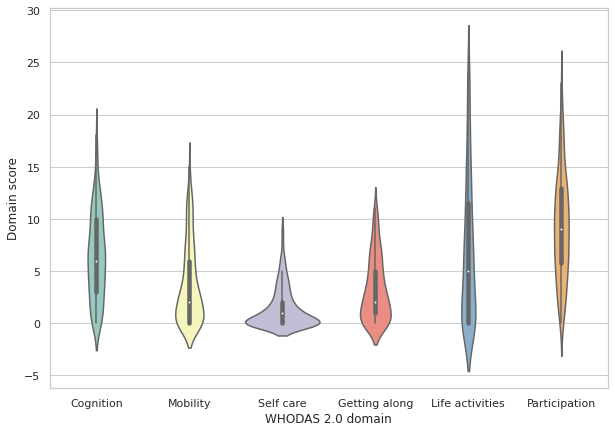

In [39]:
import seaborn as sns
sns.set_theme(style='whitegrid')

import matplotlib.pyplot as plt
plt.rcParams.update({'font.sans-serif':'Arial'})

# create violin plots of the score distribution
df_scores = {
    'domain': [],
    'score': []
}
for k,v in df_dic.items():
  df_scores['domain'] += [k.capitalize().replace('_', ' ')]*len(v)
  df_scores['score'] += v['WHODAS_tot_W'].to_list()

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.violinplot(x='domain', y='score', data=df_scores, palette='Set3', ax=ax)

ax.set(xlabel='WHODAS 2.0 domain', ylabel='Domain score');

plt.savefig(root_data_path+'score_distributions.pdf', format='pdf', dpi=300, bbox_inches='tight')


## Train the pipelines

### No feature selection

In [ ]:
dataset_all = run_pipeline_on_all_domains(df_dic, False, False)

cognition domain
---------------------
rows: 177
  Dataset       MAE      SDAE      MAPE     SDAPE       R^2  pred_var
0   Train  2.295775  1.883168  0.114789  0.094158  0.448740  7.441827
1    Test  3.828571  3.009373  0.191429  0.150469 -0.411565  6.672653

mobility domain
---------------------
rows: 196
  Dataset       MAE      SDAE      MAPE     SDAPE       R^2  pred_var
0   Train  2.452229  1.900204  0.153264  0.118763  0.396768  5.688425
1    Test  3.846154  3.198866  0.240385  0.199929 -0.396127  8.549638

self_care domain
---------------------
rows: 184
  Dataset       MAE      SDAE      MAPE     SDAPE       R^2  pred_var
0   Train  1.163265  1.149036  0.116327  0.114904  0.453330  1.850340
1    Test  2.432432  2.150305  0.243243  0.215031 -1.353229  4.390066

getting_along domain
---------------------
rows: 115
  Dataset       MAE      SDAE      MAPE     SDAPE       R^2   pred_var
0   Train  1.228261  1.074439  0.102355  0.089537  0.728757   6.787807
1    Test  4.695652  2.925

### Feature selection

In [ ]:
dataset_sel = run_pipeline_on_all_domains(df_dic, True, True)

cognition domain
---------------------
rows: 177
sfs best avg score over folds:-3.225992063492063
---------------------------------------------------

Mask:
['location_time_home_max', 'steps_steps_total_count', 'steps_steps_total_std', 'sleep_duration_q50']
4 features selected
  Dataset       MAE      SDAE      MAPE     SDAPE       R^2  pred_var
0   Train  3.119718  2.281223  0.155986  0.114061  0.066117  0.909145
1    Test  3.371429  2.508109  0.168571  0.125405 -0.051020  0.873469

mobility domain
---------------------
rows: 196
sfs best avg score over folds:-3.249198717948718
---------------------------------------------------

Mask:
['location_distance_q50', 'location_clusters_count_std', 'location_time_home_min', 'steps_steps_total_count', 'steps_steps_total_q50', 'exercise_time_q50', 'activity_vehicle_min', 'activity_walking_q50', 'sleep_duration_count', 'sleep_duration_mean']
10 features selected
  Dataset       MAE      SDAE      MAPE     SDAPE       R^2  pred_var
0   Train  3.

## Coefficient plots

In [ ]:
def plot_feature_importance(df_list, figure_path=None):
    '''Create a heatmap plot of the feature importance.
    '''
    fig, axn = plt.subplots(1, len(df_list), sharex=True, sharey=True, figsize=(11,5))
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    domain_names = ['Cognition', 'Mobility', 'Self-care', 'Getting along', 'Life activities', 'Participation']
    for i, ax in enumerate(axn.flat):
        sns.heatmap(df_list[i].rename(columns=name_dict, index=name_dict), ax=ax, cmap='YlGnBu',
                    cbar=i == 0,
                    vmin=0, vmax=1,xticklabels=1,
                    cbar_ax=None if i else cbar_ax)
        ax.set(xlabel=domain_names[i])
        ax.tick_params(axis='x', which='major', labelsize=9)
        
    plt.subplots_adjust(wspace=0.04)
    fig.subplots_adjust(top=0.92)
    
    if figure_path is not None:
        plt.savefig(figure_path, format='pdf', dpi=300, bbox_inches='tight')

### LR coefficients

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# create dataframe of LR coefficients in each domain
df_list_all = []
for domain in dataset_all:
    # feature coefficient placeholder
    all_features = np.zeros(64)
    nonzeros = dataset_all[domain]['lr_coefs']
    nonzeros=nonzeros.reshape(-1,1)
    nonzeros = np.abs(nonzeros)

    # normalize the LR coefficients to the 0-1 scale
    scaler = MinMaxScaler()
    nonzeros = scaler.fit_transform(nonzeros)
    nonzeros=nonzeros.reshape(-1,)

    for idx, val in enumerate(nonzeros):
      all_features[idx]=val
      
    feat_1 = all_features[:8]
    feat_2 = all_features[8:16]
    feat_3 = all_features[16:24]
    feat_4 = all_features[24:32]
    feat_5 = all_features[32:40]
    feat_6 = all_features[40:48]
    feat_7 = all_features[48:56]
    feat_8 = all_features[56:64]

    df_list_all.append(pd.DataFrame(
          data = [feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8], 
          columns=['count','mean','std','min','q25','q50','q75','max'], 
          index = ['location_distance','location_clusters_count','location_time_home','steps_steps_total',
                    'exercise_time','activity_vehicle','activity_walking','sleep_duration']))

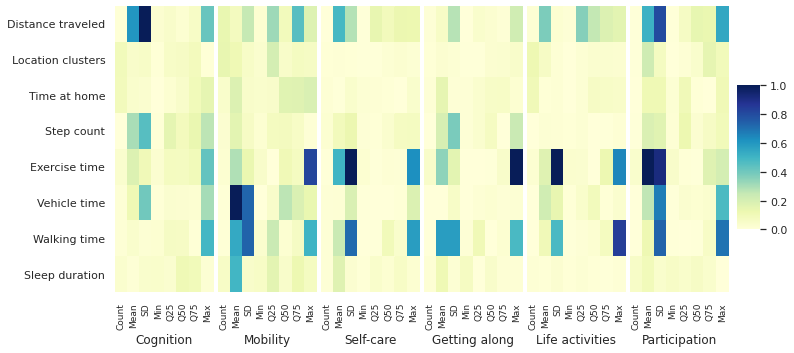

In [57]:
plot_feature_importance(df_list_all, root_data_path+'lin_reg_coeffs.pdf')

### SFS features

In [ ]:
df_list = []
for domain in dataset_sel:
    all_features = np.zeros(64)
    nonzeros = dataset_sel[domain]['selected_features']
    for x in nonzeros:
      all_features[x] = 1
      
    feat_1 = all_features[:8]
    feat_2 = all_features[8:16]
    feat_3 = all_features[16:24]
    feat_4 = all_features[24:32]
    feat_5 = all_features[32:40]
    feat_6 = all_features[40:48]
    feat_7 = all_features[48:56]
    feat_8 = all_features[56:64]

    df_list.append(pd.DataFrame(
        data = [feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8], 
        columns = ['count','mean','std','min','q25','q50','q75','max'], 
        index = ['location_distance','location_clusters_count','location_time_home','steps_steps_total',
                 'exercise_time','activity_vehicle','activity_walking','sleep_duration'])
    )

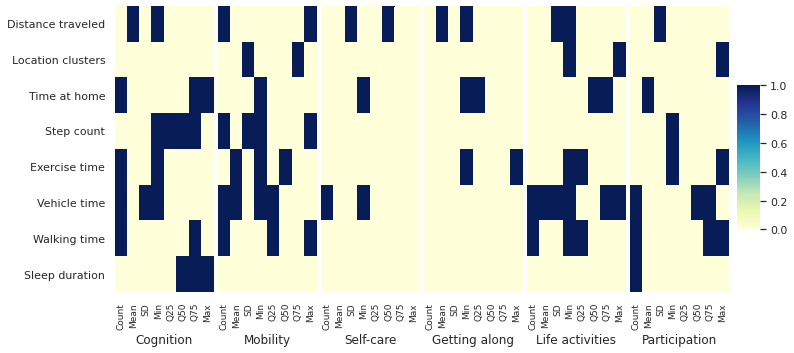

In [58]:
plot_feature_importance(df_list_all, root_data_path+'sfs_features.pdf')